<span style="font-size:3em;"><b> Challenge Data - Travel Insurance<b></span>

**SOMMAIRE:**
* Initialisation
* Analyse des données
* Recherche de corrélations
* Numérisation
* Normalisation
* I.Suréchantillonnage
* I.1 Régression logistique
* I.2 Random Forests
* I.3 XGBoost: Extreme Gradient Boosting
* I.4 SVC : Support Vector Classifier
* II.Sous-échantillonnage
* II.1 Régression logistique
* II.2 Random Forests
* II.3 XGBoost: Extreme Gradient Boosting
* II.4 SVC : Support Vector Classifier

# Présentation du dataset

Il s'agit d'un dataset d'une société tierce de services d'assurance de voyages basée à Singapour.  
Ce dataset permet de déterminer quel client prend ou ne prend pas une assurance de voyage.  
Les attributs présents dans ce dataset sont les suivants:
* Agency: Nom de l'agence
* AgencyType: Type d'agence de l'assurance de voyage
* DistributionChannel: Canal de distribution des agences d'assurance voyage
* ProductName: Nom de l'assurance voyage 
* Duration: Durée du voyage
* **Claim: Assurance prise ou non (Objectif de prédiction)**
* Destination: Destination du voyage
* NetSales: Montant net du prix de l'assurance
* Commission: Commission reçue pour l'agence d'assurance
* Gender: Genre du client (M: Homme, F: Femme)
* Age: Âge du client

# Initialisation

In [ ]:
# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn import preprocessing

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML # permet d'afficher du code html dans jupyter

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn import ensemble

Fonction pour standardiser les données quantitatives :

In [ ]:
def scale_feat(df,cont_feat) :
    df1=df
    scaler = preprocessing.RobustScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat])
    return df1

Fonction pour tracer les courbes d'apprentissage sur l'ensemble d'apprentissage et l'ensemble de validation :

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.show()

Fonction pour tracer la courbe ROC :

In [ ]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
    plt.plot([0,0,1],[0,1,1],'g:')     # meilleure courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

Importation du dataset:

In [ ]:
#Importer le dataset
df = pd.read_csv("../input/travel-insurance/travel insurance.csv")
#Modifier les noms des colonnes
df = df.rename(index=str, columns={"Agency Type": "AgencyType"})
df = df.rename(index=str, columns={"Distribution Channel": "DistributionChannel"})
df = df.rename(index=str, columns={"Product Name": "ProductName"})
df = df.rename(index=str, columns={"Net Sales": "NetSales"})
df = df.rename(index=str, columns={"Commision (in value)": "Commision"})

Affichage des 10 premiers éléments:

In [ ]:
df.head(10)

# Analyse des données

Affichage des informations:

In [ ]:
df.info()

On remarque qu'il manque dans beaucoup de lignes les données sur le genre de la personne. Ce qui est compréhensible d'un point de vue éthique.  
1-(18219/63326) = 0.7123
On remarque que 71% des données sur le genre sont manquantes, cette colonne n'est donc pas pertinente et nous allons la retirer.

In [ ]:
#Retirer la colonne des genres
df = df.drop(['Gender'], axis=1)

A l'aide des autres notebooks, nous savons qu'il y existe quelques coquilles au niveau de certaines données:  
1. Quelques valeurs de *Duration* sont négatives ou nulles, ce qui est impossible car un voyage doit avoir une durée supérieur à 0.  
2. Certaines valeurs du prix de l'assurance sont négatives
3. Certaines valeurs de commission sont supérieurs aux prix de l'assurance, ce qui est impossible car la commission doit avoir une valeur inférieur au prix de l'assurance.
4. Certaines personnes ont un âge supérieur à 100 ans, ce qui est possible mais peu crédible qu'une personne de cet âge voyage.

1. Quelques valeurs de *Duration* sont négatives ou nulles, ce qui est impossible car un voyage doit avoir une durée supérieur à 0.  
Nous allons vérifier la colonne *Duration* et compter le nombre de valeurs inféreurs à 1:

In [ ]:
df[df['Duration']<=0].Duration.count()

On remarque que 66 valeurs sont éronnés et allons les remplacer par une valeur aléatoire suivant une loi normale:

In [ ]:
import math
def replace_duration(df,col) :
    df1 = df.copy()
    n = df.shape[0]
    m = df['Duration'].mean()
    s = df[col].std()
    for i in range(n) :
        if df.loc[str(i),col] <= 0 :
            df1.loc[str(i),col] = abs(np.random.normal(m,s))
    return df1

df = replace_duration(df,'Duration')
#On revérifie
dfCheckDuration=df['Duration']<=0
dfCheckDuration.sum()

2. Certaines valeurs du prix de l'assurance sont négatives

In [ ]:
df[df['NetSales']<0].NetSales.count()

In [ ]:
df[df['NetSales']<0]

On remarque que ces valeurs sont cohérentes mais uniquement avec un signe moins en trop, nous allons donc les remplacer par leurs valeurs absolues.

In [ ]:
def replace_abs(df,col) :
    df1 = df.copy()
    n = df.shape[0]
    for i in range(n) :
        if df.loc[str(i),col] < 0 :
            df1.loc[str(i),col] = abs(df.loc[str(i),col])
    return df1

df = replace_abs(df,'NetSales')
df[df['NetSales']<0].NetSales.count()

3. Certaines valeurs de commission sont supérieurs aux prix de l'assurance, ce qui est impossible car la commission doit avoir une valeur inférieur au prix de l'assurance.

In [ ]:
df[df['NetSales']<df['Commision']].NetSales.count()

Nous allons donc remplacer la valeur de la commission par 0.

In [ ]:
df.loc[df['NetSales']<df['Commision'], 'Commision'] = 0
df[df['NetSales']<df['Commision']].NetSales.count()

4. Certaines personnes ont un âge supérieur à 100 ans, ce qui est possible mais peu crédible qu'une personne de cet âge voyage.

In [ ]:
df[df["Age"] >100].Age.count()

In [ ]:
def replace_abs(df,col) :
    df1 = df.copy()
    n = df.shape[0]
    m = df['Duration'].mean()
    s = df[col].std()
    for i in range(n) :
        if df.loc[str(i),col] > 100 :
            df1.loc[str(i),col] = np.random.normal(m,s)
    return df1

df = replace_abs(df,'Age')
df[df['Age']>100].Age.count()

Nous avons 927 Yes et 62 399 No . L'ensemble de données est très déséquilibré, la classe positive (yes) représente seulement 1,48 % de tous les clients.

# Recherche de corrélations

Création de la fonction de Cramer:

In [ ]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Utilisation d'une "heatmap" pour visualiser l'ensemble des corrélations et regroupement des paramètres par cluster classé par proximité:

In [ ]:
categorical=['Agency', 'AgencyType', 'DistributionChannel', 'ProductName',  'Destination','Claim']
cramers=pd.DataFrame({i:[cramers_v(df[i],df[j]) for j in categorical] for i in categorical})
cramers['column']=[i for i in categorical if i not in ['memberid']]
cramers.set_index('column',inplace=True)

#categorical correlation heatmap

sns.clustermap(cramers, cmap="coolwarm")

On remarque un cluster pricipal contenant Agency, AgencyType, ProductName.  
Ce qui est logique puisque le nom de l'assurance est lié au nom de l'agence qui est elle liée au type d'agence.
Mais l'on ne constate pas de paramètre avec un impact majeur sur le choix du client à pendre une assurance ou non.

# Catégorisation

Comme la plupart des algorithmes ont besoin de données numériques, nous allons remplacer les chaînes de caractères:  
* Claim : No devient 0 et Yes devient 1
* DistributionChannel: Offline devient 0 et Online devient 1
* Autres: On va utiliser la fonction ***get_dummies*** de Pandas permettant de transformer les colonnes des chaînes de caratères en chiffres binaires:

In [ ]:
df.DistributionChannel = df.DistributionChannel.map({"Offline":0, "Online":1})
df.Claim = df.Claim.map({"No":0, "Yes":1})
df.head()
df = pd.get_dummies(data=df, columns=['Agency','AgencyType','ProductName','Destination'])

# Normalisation

Nous avons bien équilibré l'ensemble d'apprentissage et de test.

In [ ]:
cont_feat = list(set(df.columns) -{'Claim'})
df=scale_feat(df,cont_feat)

On vérifie que la moyenne tend bien vers 0:

In [ ]:
df[cont_feat].describe()

# I. Suréchantillonnage

Nous allons maintenant analyser s'il y a un désiquilibre au sein des données:

In [ ]:
df.Claim.value_counts()

Etant donné le très grand déséquilibre entre les 2 ensembles, nous allons effectuer un sur-échantillonnage avec la méthode SMOTE :  
Construction des ensembles d'apprentissage et de test :

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['Claim'], axis=1)
y = df.Claim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Utilisation de la méthode SMOTE :

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)
X_test, y_test = smote.fit_sample(X_test, y_test)

On vérifie :

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

# I.1 Régression logistique

Calcul du score de précision avec la méthode de Régression logistique.

In [ ]:
#Importation de la méthode de régression logistique
from sklearn.linear_model import LogisticRegression
#Entrainement
lr = LogisticRegression()
lr.fit(X_train,y_train)
#Prédiction
y_lr = lr.predict(X_test)

In [ ]:
#Score de précision
print(lr.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_lr))
#Matrice de confusion
pd.crosstab(y_test, y_lr, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
#plot_learning_curve(lr, X_train, y_train)

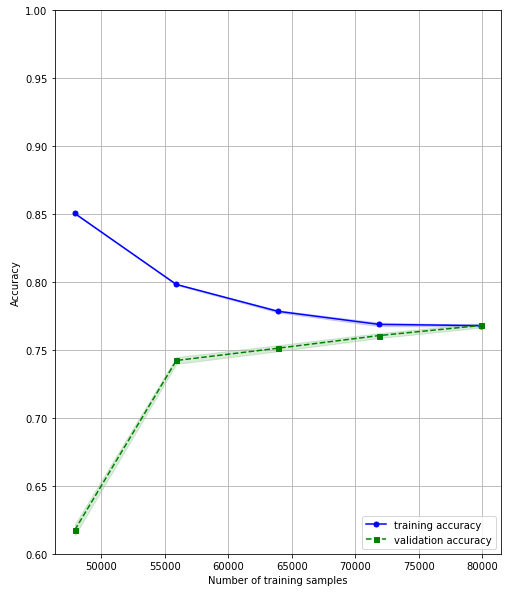

In [ ]:
#Courbe ROC
plot_roc_curve(lr,X_test,y_test)

# I.2 Random Forests

Calcul du score de précision avec la méthode Random Forests.

In [ ]:
#Importation de la méthode random forests
from sklearn import ensemble
#Entrainement
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
#Prédiction
y_rf = rf.predict(X_test)

In [ ]:
#Score de précision
print(rf.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_rf))
#Matrice de confusion
pd.crosstab(y_test, y_rf, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
#plot_learning_curve(rf, X_train, y_train)

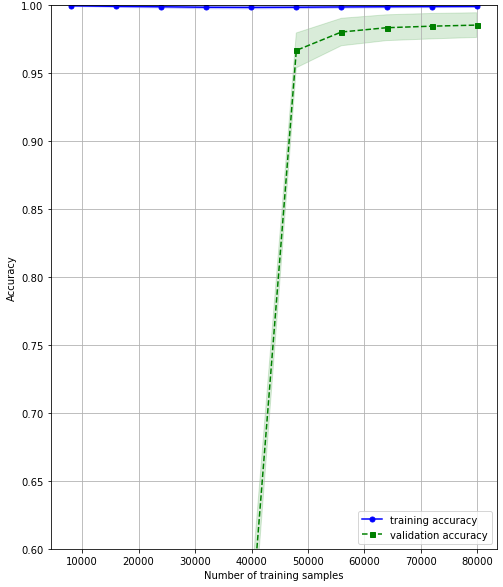

In [ ]:
#Courbe ROC
plot_roc_curve(rf,X_test,y_test)

Utilisation d'hyperparamètres :

Parmi les hyperparamètres de l'algorithme qui peuvent avoir un impact sur les performances, on a :

* n_estimators : le nombre d'arbres de décision de la forêt aléatoire
* min_samples_leaf : le nombre d'échantillons minimum dans une feuille de chaque arbre
* max_features : le nombre de caractéristiques à prendre en compte lors de chaque split
On va tester plusieurs combianaisons de paramètre pour obtenir la meilleur possible.

In [ ]:
from sklearn import model_selection
param_grid = {
              'n_estimators': [10, 100, 500],
              'min_samples_leaf': [1, 20, 50],
              'max_features': [1, 2, 4, 8]
             }
estimator = ensemble.RandomForestClassifier()
rf_gs = model_selection.GridSearchCV(estimator, param_grid)

In [ ]:
#Détermination du meilleur groupe de paramètres
rf_gs.fit(X_train, y_train)

In [ ]:
#Affichage du meilleur groupe de paramètre
print(rf_gs.best_params_)

In [ ]:
#Utilisation des meilleurs paramètres
rf2 = rf_gs.best_estimator_
y_rf2 = rf2.predict(X_test)
rf_score = accuracy_score(y_test, y_rf2)
print(rf_score)
print(classification_report(y_test, y_rf2))

In [ ]:
#Commenté pour éviter un temps de chargement trop long
#plot_learning_curve(rf2, X_train, y_train)

In [ ]:
#Courbe ROC
plot_roc_curve(rf2,X_test,y_test)

# I.3 XGBoost: Extreme Gradient Boosting

In [ ]:
#Importation de la méthode XGBClassifier
from xgboost import XGBClassifier
#Entrainement
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
#Prédiction
y_xgb = xgb.predict(X_test)

In [ ]:
#Score de précision
print(xgb.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_xgb))
#Matrice de confusion
pd.crosstab(y_test, y_xgb, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
#plot_learning_curve(xgb, X_train, y_train)

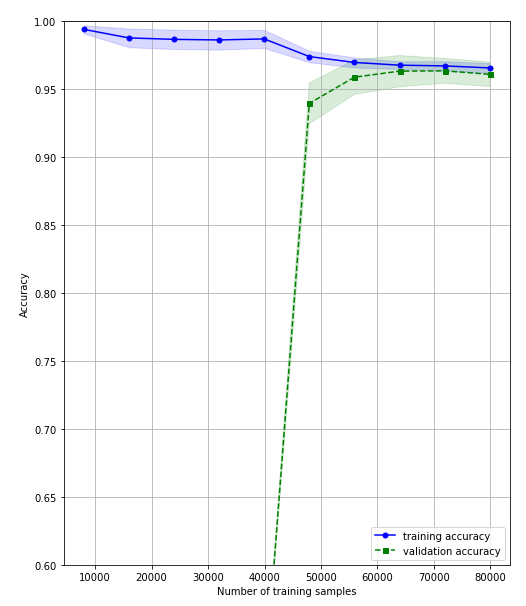

In [ ]:
#Courbe ROC
plot_roc_curve(xgb,X_test,y_test)

# I.4 SVC : Support Vector Classifier

In [ ]:
#Importation de la méthode SVC
from sklearn import svm
#Entrainement
clf = svm.SVC()D
clf.fit(X_train, y_train)
#Prédiction
y_clf = clf.predict(X_test)

In [ ]:
#Score de précision
print(clf.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_clf))
#Matrice de confusion
pd.crosstab(y_test, y_clf, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
#plot_learning_curve(clf, X_train, y_train)

# II. Sous-échatillonage

Comme nous avons pu le voir précédement avec le suréchantillonage, il y a bien un désiquilibre.  
Nous allons maintenant essayer un sous échantillonage pour comparer les résultats :

In [ ]:
df.Claim.value_counts()

On va garder autant de réponses Yes que de réponse No dans l'ensemble d'apprentissage et de test, en tirant aléatoirement ceux qu'on va garder.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['Claim'], axis=1)
y = df.Claim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler()
X_train, y_train = rus.fit_sample(X_train, y_train)
X_test, y_test = rus.fit_sample(X_test, y_test)

On vérifie :

In [ ]:
y_train.value_counts()

# II.1 Régression logistique

Calcul du score de précision avec la méthode de Régression logistique.

In [ ]:
#Importation de la méthode de régression logistique
from sklearn.linear_model import LogisticRegression
#Entrainement
lr = LogisticRegression()
lr.fit(X_train,y_train)
#Prédiction
y_lr = lr.predict(X_test)

In [ ]:
#Score de précision
print(lr.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_lr))
#Matrice de confusion
pd.crosstab(y_test, y_lr, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
plot_learning_curve(lr, X_train, y_train)

In [ ]:
#Courbe ROC
plot_roc_curve(lr,X_test,y_test)

# II.2 Random Forests

Calcul du score de précision avec la méthode Random Forests.

In [ ]:
#Importation de la méthode random forests
from sklearn import ensemble
#Entrainement
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
#Prédiction
y_rf = rf.predict(X_test)

In [ ]:
#Score de précision
print(rf.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_rf))
#Matrice de confusion
pd.crosstab(y_test, y_rf, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
plot_learning_curve(rf, X_train, y_train)

In [ ]:
#Courbe ROC
plot_roc_curve(rf,X_test,y_test)

Utilisation d'hyperparamètres :

Parmi les hyperparamètres de l'algorithme qui peuvent avoir un impact sur les performances, on a :

* n_estimators : le nombre d'arbres de décision de la forêt aléatoire
* min_samples_leaf : le nombre d'échantillons minimum dans une feuille de chaque arbre
* max_features : le nombre de caractéristiques à prendre en compte lors de chaque split
On va tester plusieurs combianaisons de paramètre pour obtenir la meilleur possible.

In [ ]:
from sklearn import model_selection
param_grid = {
              'n_estimators': [10, 100, 500],
              'min_samples_leaf': [1, 20, 50],
              'max_features': [1, 2, 4, 8]
             }
estimator = ensemble.RandomForestClassifier()
rf_gs = model_selection.GridSearchCV(estimator, param_grid)

In [ ]:
#Détermination du meilleur groupe de paramètres
rf_gs.fit(X_train, y_train)

In [ ]:
#Affichage du meilleur groupe de paramètre
print(rf_gs.best_params_)

In [ ]:
rf2 = rf_gs.best_estimator_
y_rf2 = rf2.predict(X_test)
rf_score = accuracy_score(y_test, y_rf2)
print(rf_score)
print(classification_report(y_test, y_rf2))

In [ ]:
#Commenté pour éviter un temps de chargement trop long
plot_learning_curve(rf, X_train, y_train)

In [ ]:
#Courbe ROC
plot_roc_curve(rf,X_test,y_test)

# II.3 XGBoost: Extreme Gradient Boosting

In [ ]:
#Importation de la méthode XGBClassifier
from xgboost import XGBClassifier
#Entrainement
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
#Prédiction
y_xgb = xgb.predict(X_test)

In [ ]:
#Score de précision
print(xgb.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_xgb))
#Matrice de confusion
pd.crosstab(y_test, y_xgb, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
plot_learning_curve(xgb, X_train, y_train)

In [ ]:
#Courbe ROC
plot_roc_curve(xgb,X_test,y_test)

# II.4 SVC : Support Vector Classifier

In [ ]:
#Importation de la méthode SVC
from sklearn import svm
#Entrainement
clf = svm.SVC()
clf.fit(X_train, y_train)
#Prédiction
y_clf = clf.predict(X_test)

In [ ]:
#Score de précision
print(clf.score(X_test,y_test))
#Détails du score
print(classification_report(y_test, y_clf))
#Matrice de confusion
pd.crosstab(y_test, y_clf, rownames=['Reel'], colnames=['Prediction'], margins=True)

In [ ]:
#Commenté pour éviter un temps de chargement trop long
plot_learning_curve(clf, X_train, y_train)